#Imports

In [53]:
import librosa
import audioread
import numpy as np
import scipy
import scipy.signal
import collections
import matplotlib.pyplot as plt
import os.path
#import IPython.display
%matplotlib inline

#Definitions

In [72]:
''' for faster speeds you may want to convert the files BEFORE.
ffmpeg -i "infile" -acodec pcm_s16le -ac 1 -ar 16000 "outfile"
'''

filename = "mix.wav"
sr = 16000
framesize = 2**12
n_blocks = 64
feature_dim = 80

kernel_size = 60

feature_buffer = collections.deque() #maxlen=horizon * n_blocks
rec_buffer = collections.deque() 

#Functions

In [3]:
def get_audiofile_duration(file):
    with audioread.audio_open(file) as f:
        return f.duration

In [48]:
def recurrence_matrix(data, metric='sqeuclidean',
                      sym=False, axis=-1):

    data = np.atleast_2d(data)

    # Swap observations to the first dimension and flatten the rest
    data = np.swapaxes(data, axis, 0)
    t = data.shape[0]
    data = data.reshape((t, -1))
    
#    print("data shape: ", np.shape(data))

#     if width < 1:
#         raise ParameterError('width must be at least 1')

#     if k is None:
#         if t > 2 * width + 1:
#             k = 2 * np.ceil(np.sqrt(t - 2 * width + 1))
#         else:
#             k = 2

#     k = int(k)

    # Build the distance matrix
    D = scipy.spatial.distance.cdist(data, data, metric=metric)

    # Max out the diagonal band
#    D = D + __band_infinite(t, width)

    # build the recurrence plot
#    rec = np.zeros((t, t), dtype=bool)

    # get the k nearest neighbors for each point
#     for i in range(t):
#         for j in np.argsort(D[i])[:k]:
#             rec[i, j] = True

    #my version 
    rec = D

    # symmetrize
    if sym:
        rec = rec * rec.T

    return rec

In [4]:
def create_kernel(size):
    kernel = np.zeros([2*kernel_size+1, 2*kernel_size+1], dtype='int')
    kernel[:kernel_size, :kernel_size] = 1
    kernel[kernel_size+1:, kernel_size+1:] = 1
    kernel[kernel_size+1:, :kernel_size] = -1
    kernel[:kernel_size, kernel_size+1:] = -1
    return kernel

In [5]:
def correlate2d_diagonal(matrix, kernel):
#    assert np.shape(matrix)[0] == np.shape(matrix)[1]
#    assert np.shape(kernel)[0] == np.shape(kernel)[1]
    length = np.shape(matrix)[0]
    L = np.shape(kernel)[0] // 2
    
    result = np.zeros(length-L)
    for i in range(length):
        for k in range(-L, L):
            if i+k < 0 or i+k >= length:
                break
            for l in range(-L, L):
                if i+l < 0 or i+l >= length:
                    break
                result[i-L] += matrix[i+l, i+k] * kernel[L+l, L+k]
    return result

# Main Program

In [73]:
blocksize = n_blocks * framesize/sr #seconds

#horizon = 4 * n_blocks 
horizon = 2*(2*kernel_size+1)
horizon_step = horizon // 2

#make sure there is enough data for the filter
assert horizon_step >= 2*kernel_size+1 

duration = get_audiofile_duration(filename)
segments = np.arange(0, duration, blocksize) # replace fixed value with duration!

kernel = create_kernel(kernel_size)

# initalize and clear all buffers
feature_buffer.clear()
rec_buffer.clear()
novelty_buffer = []
novelty_calc_matrix = np.zeros((2*horizon, 2*horizon))

# iterate through the whole file
for i, block in enumerate(segments):
    
    print("@block: ", block)
    
    # load chunk of audio file (~300ms)
    y = librosa.load(filename, sr=sr, mono=True, offset=block, duration=blocksize)[0]
    
    # constant Q transform (~1500ms)
    CQ = librosa.core.cqt(y, sr=sr, hop_length=framesize, fmin=None, n_bins=feature_dim, bins_per_octave=12, tuning=None, resolution=2, aggregate=None, norm=1, sparsity=0.01)
    feature_buffer.extend(CQ.T)
 
    while len(feature_buffer) >= horizon:
        features = [feature_buffer.popleft() for x in range(0, horizon_step)]
        features.extend(list(feature_buffer)[:horizon_step])
        
        # compute recurrence matrix (~16ms)
        R_CQ = librosa.segment.recurrence_matrix(np.array(features).T, k=None, width=1, metric='sqeuclidean', sym=True, axis=-1)
        #R_CQ = recurrence_matrix(np.array(features).T, metric='sqeuclidean', sym=False, axis=-1)

        rec_buffer.extend(R_CQ)
    
    while len(rec_buffer) >= 3*horizon:
        
        # fill the matrix for the calculation
        if novelty_buffer: # only ommit if empty
            novelty_calc_matrix[:horizon, :horizon] = [rec_buffer.popleft() for x in range(0, horizon)]
        novelty_calc_matrix[horizon_step:horizon+horizon_step, horizon_step:horizon+horizon_step] = np.array(list(rec_buffer)[:horizon])
        novelty_calc_matrix[horizon:2*horizon, horizon:2*horizon] = np.array(list(rec_buffer)[horizon:2*horizon])
        
        # calculate the novelty
        lower_limit = horizon_step - kernel_size
        upper_limit = horizon + kernel_size
        #novelty = correlate2d_diagonal(novelty_calc_matrix[lower_limit:upper_limit, lower_limit:upper_limit], kernel)
        novelty = scipy.signal.convolve2d(novelty_calc_matrix[lower_limit:upper_limit, lower_limit:upper_limit], kernel, mode='valid')
        novelty_buffer.extend(novelty.diagonal())
        
#         print(novelty)
        

@block:  0.0
@block:  16.384
@block:  32.768
@block:  49.152
@block:  65.536
@block:  81.92
@block:  98.304
@block:  114.688
@block:  131.072
@block:  147.456
@block:  163.84
@block:  180.224
@block:  196.608
@block:  212.992
@block:  229.376
@block:  245.76
@block:  262.144
@block:  278.528
@block:  294.912
@block:  311.296
@block:  327.68
@block:  344.064
@block:  360.448
@block:  376.832
@block:  393.216
@block:  409.6
@block:  425.984
@block:  442.368
@block:  458.752
@block:  475.136
@block:  491.52
@block:  507.904
@block:  524.288
@block:  540.672
@block:  557.056
@block:  573.44
@block:  589.824
@block:  606.208
@block:  622.592
@block:  638.976
@block:  655.36
@block:  671.744
@block:  688.128
@block:  704.512
@block:  720.896
@block:  737.28
@block:  753.664
@block:  770.048
@block:  786.432
@block:  802.816
@block:  819.2
@block:  835.584
@block:  851.968
@block:  868.352
@block:  884.736
@block:  901.12
@block:  917.504
@block:  933.888
@block:  950.272
@block:  966.656
@bl

KeyboardInterrupt: 

In [57]:
#R_CQ = librosa.segment.recurrence_matrix(np.array(list(feature_buffer)).T, k=None, width=1, metric='sqeuclidean', sym=True, axis=-1)
np.shape(recurrence_buffer)
#print(len(list(feature_buffer)))
#print(feature_buffer.count)

(715, 256)

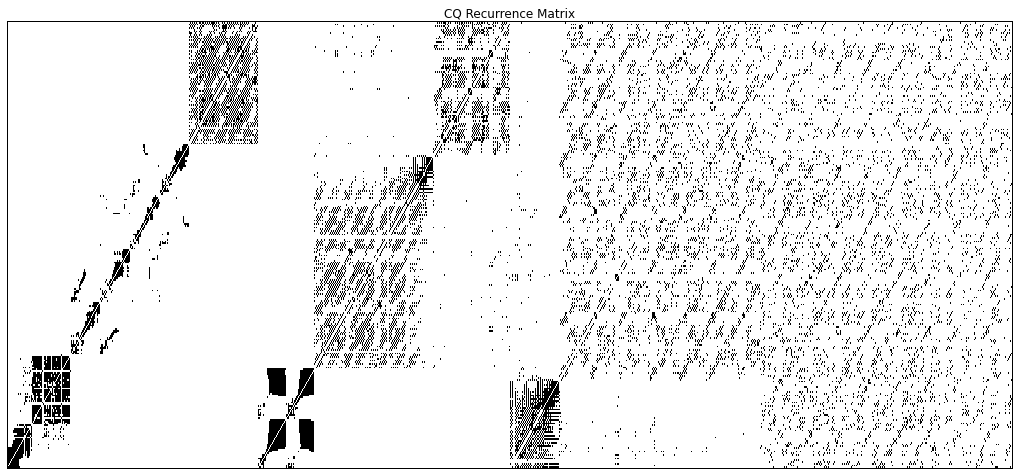

In [77]:
plt.figure(figsize=(18,8))

librosa.display.specshow(np.array(recurrence_buffer).T)

plt.title('CQ Recurrence Matrix')

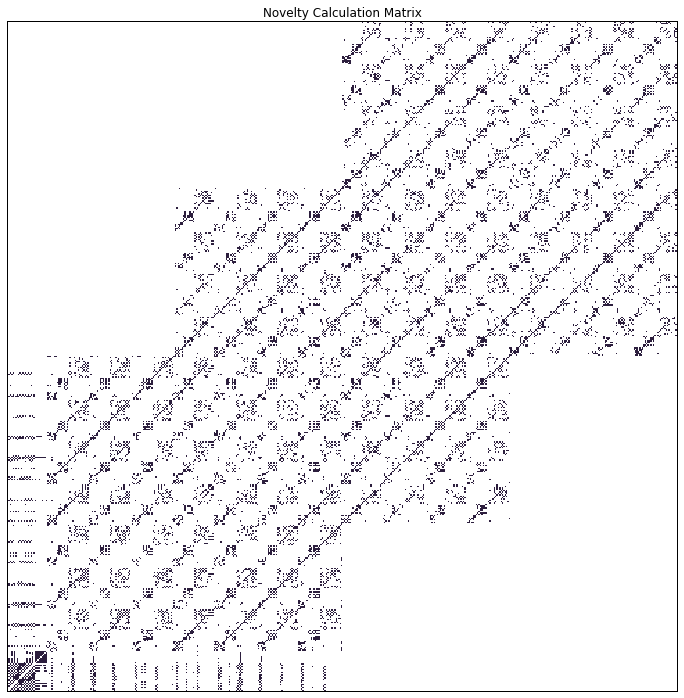

In [74]:
plt.figure(figsize=(12,12))

librosa.display.specshow(np.array(novelty_calc_matrix).T)

plt.title('Novelty Calculation Matrix')

#Plot Novelty

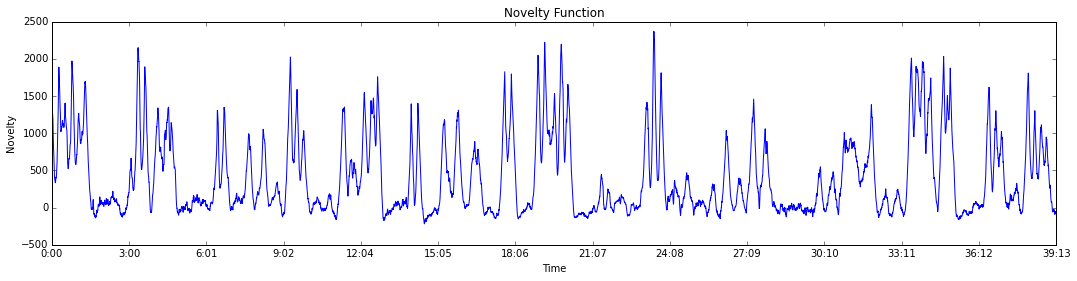

In [83]:
plt.figure(figsize=(18,4))
plt.title("Novelty Function")
plt.plot(novelty_buffer)
plt.ylabel('Novelty')
plt.xlabel('Time')
locs = np.arange(0, len(novelty_buffer))
plt.xlim([locs[0], locs[-1]])
librosa.display.time_ticks(locs, librosa.core.samples_to_time(locs, sr=sr/framesize), n_ticks=14)
plt.show()